In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import tensorflow as tf
import numpy as np
import torch
import math
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
data = '/content/drive/MyDrive/trajectories_imu/df_RGC.pkl'
with open(data, 'rb') as file:
    data = pickle.load(file)

label = '/content/drive/MyDrive/trajectories_imu/labels_RGC.pkl'
with open(label, 'rb') as file:
    labels = pickle.load(file)

labels = labels.values
umbral = 50
labels = np.array([[1,0] if label < umbral else [0,1] for label in labels])

In [12]:
data = np.reshape(data,(data.shape[0], data.shape[2],3))
print(data.shape,len(labels))

(102, 1127, 3) 102


In [13]:
def build_model(lr=0.001, units_lstm=64, units_lstm_2=32, units_dense=16):
    model = tf.keras.Sequential()

    # Capa LSTM 1
    model.add(layers.LSTM(units_lstm, return_sequences=True, input_shape=(data.shape[1], data.shape[2])))

    # Capa LSTM 2
    model.add(layers.LSTM(units_lstm_2, return_sequences=False))

    # Capa totalment connectada
    model.add(layers.Dense(units_dense, activation='relu')) # ReLU per evitar la saturació de gradients

    # Capa final totalment connectada amb funció d'activació sigmoide
    model.add(layers.Dense(2, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(y_train.shape, y_test.shape)

def create_dataloader(X_train, y_train, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    return dataset

(81, 2) (21, 2)


# HYPERPARAMETER TUNNING

In [15]:
param_grid = {
    'lr': [0.001, 0.01, 0.1],  # Learning Rate
    'units_lstm': [32, 64, 128],  # Unitats en la primera capa GRU
    'units_lstm_2': [16, 32, 64],  # Unitats en la segona capa GRU,
    'units_dense': [8, 16, 32]
}

keras_model = KerasClassifier(build_fn=build_model, verbose=0) #especificar el contstructor del model + si volem imprimir el progres de l'entrenament

#cross-validation
grid_search = RandomizedSearchCV (keras_model, param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

<ipython-input-15-8c5b93ec2c45>:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=build_model, verbose=0) #especificar el contstructor del model + si volem imprimir el progres de l'entrenament


In [17]:
#evaluacio del model amb els millor hiperparàmetres
best_model = grid_result.best_estimator_.model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("\nLoss al conjunt de prova:", test_loss)
print("Accuracy al conjunt de prova:", test_acc)

1/1 [==============================] - 0s 360ms/step - loss: 0.6283 - accuracy: 0.6667

Loss al conjunt de prova: 0.6283060908317566
Accuracy al conjunt de prova: 0.6666666865348816


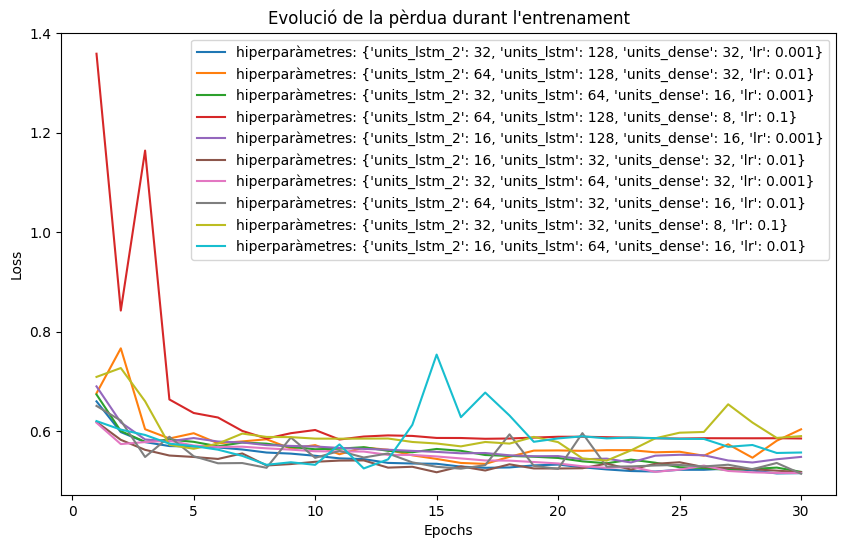

In [18]:
# Obtenir l'historial d'entrenament per a cada combinació d'hiperparàmetres
loss_history = []
for params, cv_results in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score']):
    model = build_model(**params)
    history = model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=0)
    loss_history.append(history.history['loss'])

plt.figure(figsize=(10, 6))
for i, loss in enumerate(loss_history):
    plt.plot(range(1, len(loss)+1), loss, label=f"hiperparàmetres: {grid_result.cv_results_['params'][i]}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la pèrdua durant l\'entrenament')
plt.legend()
plt.show()

In [19]:
print("Millors hiperparàmetres:")
print(grid_result.best_params_)

print("\nMillor score:")
print(grid_result.best_score_)

Millors hiperparàmetres:
{'units_lstm_2': 32, 'units_lstm': 128, 'units_dense': 32, 'lr': 0.001}

Millor score:
0.7283950845400492


Epoch 1/20
6/6 [==============================] - 10s 1s/step - loss: 0.6056 - accuracy: 0.6543
Epoch 2/20
6/6 [==============================] - 6s 977ms/step - loss: 0.5879 - accuracy: 0.7284
Epoch 3/20
6/6 [==============================] - 7s 1s/step - loss: 0.5769 - accuracy: 0.7284
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.5784 - accuracy: 0.7284
Epoch 5/20
6/6 [==============================] - 6s 975ms/step - loss: 0.5814 - accuracy: 0.7284
Epoch 6/20
6/6 [==============================] - 6s 947ms/step - loss: 0.5653 - accuracy: 0.7284
Epoch 7/20
6/6 [==============================] - 6s 936ms/step - loss: 0.5592 - accuracy: 0.7284
Epoch 8/20
6/6 [==============================] - 6s 957ms/step - loss: 0.5726 - accuracy: 0.7284
Epoch 9/20
6/6 [==============================] - 7s 1s/step - loss: 0.5699 - accuracy: 0.7284
Epoch 10/20
6/6 [==============================] - 6s 982ms/step - loss: 0.5640 - accuracy: 0.7284
Epoch 11/20
6/6 [=============

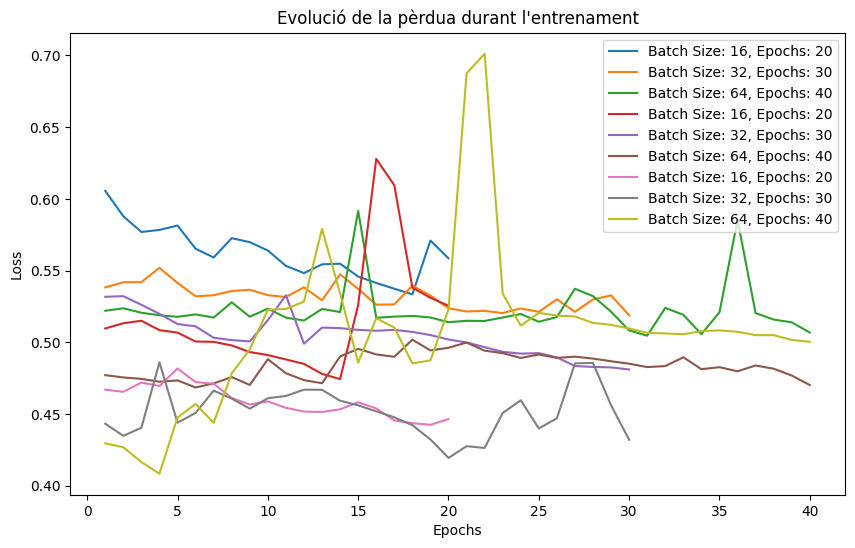

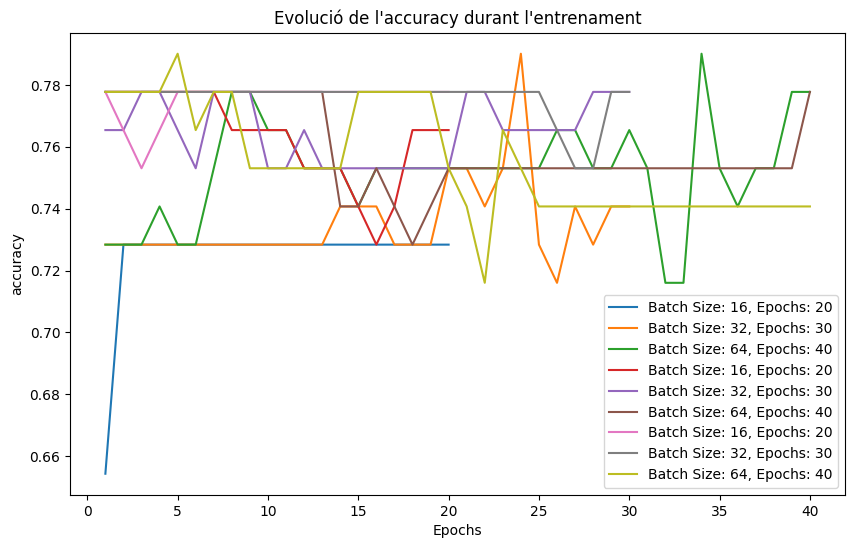

In [21]:
# Emmagatzemar els hiperparàmetres
units_lstm_2, units_lstm, units_dense, lr = grid_result.best_params_['units_lstm_2'], grid_result.best_params_['units_lstm'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
model = build_model(lr=lr, units_lstm=units_lstm, units_lstm_2=units_lstm_2, units_dense=units_dense)

#Diferents valors a provar
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

loss_values = []
mae_values = []

for batch_size in batch_sizes:
    for epochs in epochs_values:
        train_dataset = create_dataloader(X_train, y_train, batch_size)
        history = model.fit(train_dataset, epochs=epochs, verbose=1)

        loss_values.append(history.history['loss'])
        mae_values.append(history.history['accuracy'])

#Graficar l'evolució de les proves (loss)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(loss_values[i])+1), loss_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la pèrdua durant l\'entrenament')
plt.legend()
plt.show()

#Graficar l'evolució de les proves (mae)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(mae_values[i])+1), mae_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Evolució de l\'accuracy durant l\'entrenament')
plt.legend()
plt.show()


In [22]:
# Número de Batchs i Epochs a provar
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

best_acc = float('inf')
best_batch_size = None
best_epochs = None

# Emmagatzemar els hiperparàmetres
units_lstm_2, units_lstm, units_dense, lr = grid_result.best_params_['units_lstm_2'], grid_result.best_params_['units_lstm'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
# Cerca d'hiperparàmetres
for batch_size in batch_sizes:
    for epochs in epochs_values:
        model = build_model(lr=lr, units_lstm=units_lstm, units_lstm_2=units_lstm_2, units_dense=units_dense)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

        _, test_mae = model.evaluate(X_test, y_test, verbose=0)

        if test_mae < best_acc:
            best_acc = test_mae
            best_batch_size = batch_size
            best_epochs = epochs

print("Millor combinació d'hiperparàmetres:")
print("Batch size:", best_batch_size)
print("Epochs:", best_epochs)
print("accuracy al conjunt de prova:", best_acc)

Millor combinació d'hiperparàmetres:
Batch size: 32
Epochs: 30
accuracy al conjunt de prova: 0.6190476417541504


# Model final

In [23]:
# Emmagatzemar els hiperparàmetres
units_lstm_2, units_lstm, units_dense, lr = grid_result.best_params_['units_lstm_2'], grid_result.best_params_['units_lstm'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
batch_size = best_batch_size

#creació i compilació model
final_model = build_model(lr=lr, units_lstm=units_lstm, units_lstm_2=units_lstm_2, units_dense=units_dense)

# Creació del DataLoader
train_dataset = create_dataloader(X_train, y_train, batch_size)

#entrenament del model amb els hyperparametres trobats
final_model.fit(train_dataset, epochs=best_epochs, verbose=0)

#Evaluació amb el conjunt test
test_dataset = create_dataloader(X_test, y_test, batch_size)
test_loss, test_mae = final_model.evaluate(test_dataset, verbose=0)
print(f"Loss al conjunt de prova: {test_loss}")
print(f"accuracy al conjunt de prova: {test_mae}")

Loss al conjunt de prova: 0.6996921300888062
accuracy al conjunt de prova: 0.6190476417541504


In [24]:
y_pred = final_model.predict(X_test)
for i in range(len(y_test)):
  print(y_test[i],"                   ",y_pred[i])

1/1 [==============================] - 1s 1s/step
[1 0]                     [0.4895769  0.51042306]
[0 1]                     [0.19575809 0.804242  ]
[0 1]                     [0.44595692 0.554043  ]
[0 1]                     [0.21771708 0.78228295]
[0 1]                     [0.16557655 0.8344234 ]
[0 1]                     [0.5336075 0.4663925]
[1 0]                     [0.277962 0.722038]
[0 1]                     [0.4667466 0.5332535]
[0 1]                     [0.48095566 0.51904446]
[1 0]                     [0.4013695 0.5986304]
[0 1]                     [0.49690092 0.50309914]
[1 0]                     [0.4895769  0.51042306]
[0 1]                     [0.34413472 0.6558653 ]
[0 1]                     [0.15042417 0.8495759 ]
[0 1]                     [0.38792542 0.61207455]
[0 1]                     [0.3168717  0.68312824]
[0 1]                     [0.16210057 0.8378995 ]
[1 0]                     [0.16722994 0.8327701 ]
[1 0]                     [0.26642781 0.7335722 ]
[1 0]     

In [25]:
# Convertir les probabilitats en one-hot enoded vectors
preds_one_hot = np.argmax(y_pred, axis=1)
preds_one_hot_encoded = tf.keras.utils.to_categorical(preds_one_hot, num_classes=2)
y_test_one_hot = np.argmax(y_test, axis=1)

# Visualització resultats

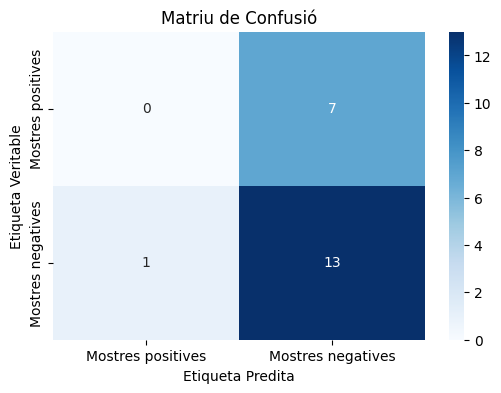

In [28]:
cm = confusion_matrix(y_test_one_hot, preds_one_hot)

clases = ['Mostres positives', 'Mostres negatives']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)

plt.xlabel('Etiqueta Predita')
plt.ylabel('Etiqueta Veritable')
plt.title('Matriu de Confusió')
plt.show()

In [29]:
report = classification_report(y_test_one_hot, preds_one_hot)

print("Report de Classificació:")
print(report)

Report de Classificació:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.65      0.93      0.76        14

    accuracy                           0.62        21
   macro avg       0.33      0.46      0.38        21
weighted avg       0.43      0.62      0.51        21

